# Phase 6: Exploratory Analysis

**Swiss Ballot Chatbot Study - Measurement Analysis**

2x2 Factorial Design: Transparency (T0/T1) x Control (C0/C1)

## Purpose

### 6A. Dashboard Behavior (C1 only: Conditions C & D)
- Frequency analysis of each dashboard variable (scope/purpose/storage/retention)
- Compare C vs D distributions for each dashboard variable (χ² + Cramér's V)
- Optional: cluster analysis of dashboard preference profiles

### 6B. Q14 Open Text ("What mattered most…")
- Theme codebook (multi-label coding)
- Theme frequencies by condition (A/B/C/D)
- Theme frequencies by donate vs decline
- Condition contrasts: A vs B, A vs C, C vs D, B vs D
- 5 short representative quotes

## Setup & Imports

In [1]:
import os
import re
import numpy as np
import pandas as pd
from scipy import stats
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter

# Import from Phase 1
from phase1_descriptive_statistics import (
    AnalysisConfig,
    load_participant_data,
    prepare_variables,
    compute_sample_flow
)

# Display settings
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)
pd.set_option('display.max_colwidth', 100)
plt.style.use('seaborn-v0_8-whitegrid')

# Significance threshold
ALPHA = 0.05

print("Setup complete!")

Setup complete!


## Configuration

In [2]:
# Set participant type: 'ai' for AI test users, 'human' for real participants
PARTICIPANT_TYPE = 'human'

config = AnalysisConfig(is_ai_participant=(PARTICIPANT_TYPE == 'ai'))
print(f"Analyzing: {'AI Test Users' if PARTICIPANT_TYPE == 'ai' else 'Human Participants'}")

Analyzing: Human Participants


## Helper Functions

In [3]:
def cramers_v(contingency_table: np.ndarray) -> tuple:
    """
    Calculate Cramér's V effect size for a contingency table.
    
    Returns: (V, interpretation)
    Interpretation: V < 0.1 = negligible, 0.1-0.2 = small, 0.2-0.4 = medium, >= 0.4 = large
    """
    chi2 = stats.chi2_contingency(contingency_table)[0]
    n = contingency_table.sum()
    min_dim = min(contingency_table.shape) - 1
    
    V = np.sqrt(chi2 / (n * min_dim)) if (n * min_dim) > 0 else 0
    
    # Interpretation
    if V < 0.1:
        interpretation = "negligible"
    elif V < 0.2:
        interpretation = "small"
    elif V < 0.4:
        interpretation = "medium"
    else:
        interpretation = "large"
    
    return V, interpretation


def chi_square_test(data: pd.DataFrame, var1: str, var2: str) -> dict:
    """
    Perform chi-square test between two categorical variables.
    
    Returns dict with contingency table, chi2, df, p, Cramér's V.
    """
    ct = pd.crosstab(data[var1], data[var2])
    chi2, p, df, expected = stats.chi2_contingency(ct)
    V, V_interp = cramers_v(ct.values)
    
    return {
        'contingency_table': ct,
        'chi2': chi2,
        'df': df,
        'p': p,
        'cramers_v': V,
        'v_interpretation': V_interp,
        'expected': expected
    }


print("Helper functions defined!")

Helper functions defined!


## Load and Prepare Data

In [4]:
# Load data
df_raw = load_participant_data(config)
df = prepare_variables(df_raw, config)

# Apply exclusions
sample_flow = compute_sample_flow(df)
df_filtered = sample_flow['df_filtered']

print(f"\nFinal sample size: N = {len(df_filtered)}")

# Filter to C1 conditions (C and D) for dashboard analysis
df_c1 = df_filtered[df_filtered['control_level'] == 1].copy()
print(f"C1 participants (Conditions C & D): n = {len(df_c1)}")
print(f"  Condition C: n = {len(df_c1[df_c1['condition'] == 'C'])}")
print(f"  Condition D: n = {len(df_c1[df_c1['condition'] == 'D'])}")

[INFO] Loaded 291 human participants from database
[INFO] Language codes cleaned: ['de-DE', 'de', 'en-GB', 'en-US', 'en', 'en-CH', 'de-CH', 'fr', 'fr-CH', 'fr-FR', 'en-AU', 'es-ES', 'it', 'gsw'] → ['de', 'en', 'fr', 'other', 'it']
[INFO] Applied language code cleaning for human participants
[INFO] Created derived variables: transparency_level, control_level, T_x_C, mc_transparency, mc_control, out_risk, attention_check_correct, attention_check_missing, attention_check_failed, dashboard fields

PHASE 1.1: SAMPLE FLOW & EXCLUSIONS
Initial N:                           291
Excluded (incomplete survey):         79
Excluded (failed attention):           7
Excluded (missing condition):          0
Excluded (missing donation):           0
------------------------------------------------------------
Final N for analysis:                205

Final sample size: N = 205
C1 participants (Conditions C & D): n = 102
  Condition C: n = 45
  Condition D: n = 57


## 6A: Dashboard Behavior Analysis

In [5]:
print("6A: DASHBOARD BEHAVIOR ANALYSIS")
print("=" * 70)
print("\nAnalyzing dashboard selections for Conditions C & D only.")

# Dashboard variables
dashboard_vars = ['dashboard_scope', 'dashboard_purpose', 'dashboard_storage', 'dashboard_retention']

# Check which variables exist
available_vars = [v for v in dashboard_vars if v in df_c1.columns]
print(f"\nAvailable dashboard variables: {available_vars}")

6A: DASHBOARD BEHAVIOR ANALYSIS

Analyzing dashboard selections for Conditions C & D only.

Available dashboard variables: ['dashboard_scope', 'dashboard_purpose', 'dashboard_storage', 'dashboard_retention']


In [6]:
# Frequency tables for each dashboard variable
print("\nDASHBOARD OPTION FREQUENCIES")
print("=" * 70)

dashboard_freq_results = {}

for var in available_vars:
    print(f"\n--- {var.upper()} ---")
    
    # Overall frequencies
    freq_overall = df_c1[var].value_counts().sort_index()
    pct_overall = (df_c1[var].value_counts(normalize=True) * 100).sort_index()
    
    # By condition (C vs D)
    freq_c = df_c1[df_c1['condition'] == 'C'][var].value_counts().sort_index()
    freq_d = df_c1[df_c1['condition'] == 'D'][var].value_counts().sort_index()
    
    pct_c = (df_c1[df_c1['condition'] == 'C'][var].value_counts(normalize=True) * 100).sort_index()
    pct_d = (df_c1[df_c1['condition'] == 'D'][var].value_counts(normalize=True) * 100).sort_index()
    
    # Combine into table
    freq_table = pd.DataFrame({
        'Overall n': freq_overall,
        'Overall %': pct_overall.round(1),
        'C n': freq_c,
        'C %': pct_c.round(1),
        'D n': freq_d,
        'D %': pct_d.round(1)
    }).fillna(0)
    
    print(freq_table)
    dashboard_freq_results[var] = freq_table


DASHBOARD OPTION FREQUENCIES

--- DASHBOARD_SCOPE ---
                 Overall n  Overall %  C n   C %  D n   D %
dashboard_scope                                            
full                    75       73.5   32  71.1   43  75.4
questions-only          11       10.8    5  11.1    6  10.5
topics-only             16       15.7    8  17.8    8  14.0

--- DASHBOARD_PURPOSE ---
                   Overall n  Overall %  C n   C %  D n   D %
dashboard_purpose                                            
academic                  69       67.6   33  73.3   36  63.2
commercial                33       32.4   12  26.7   21  36.8

--- DASHBOARD_STORAGE ---
                   Overall n  Overall %  C n   C %  D n   D %
dashboard_storage                                            
no-preference             32       31.4   14  31.1   18  31.6
swiss                     48       47.1   23  51.1   25  43.9
swiss-or-eu               22       21.6    8  17.8   14  24.6

--- DASHBOARD_RETENTION ---
    

In [7]:
# Chi-square tests: C vs D for each dashboard variable
print("\nCHI-SQUARE TESTS: CONDITION C vs D")
print("=" * 70)

chi_results = []

for var in available_vars:
    print(f"\n--- {var} ---")
    
    # Only test if both conditions have variation
    n_categories_c = df_c1[df_c1['condition'] == 'C'][var].nunique()
    n_categories_d = df_c1[df_c1['condition'] == 'D'][var].nunique()
    
    if n_categories_c > 1 and n_categories_d > 1:
        result = chi_square_test(df_c1, 'condition', var)
        
        print(f"χ²({result['df']}) = {result['chi2']:.3f}, p = {result['p']:.4f}")
        print(f"Cramér's V = {result['cramers_v']:.3f} ({result['v_interpretation']})")
        print(f"Significant: {'Yes' if result['p'] < ALPHA else 'No'}")
        
        chi_results.append({
            'Variable': var,
            'χ²': round(result['chi2'], 3),
            'df': result['df'],
            'p': round(result['p'], 4),
            'Cramér\'s V': round(result['cramers_v'], 3),
            'Interpretation': result['v_interpretation'],
            'Significant': 'Yes' if result['p'] < ALPHA else 'No'
        })
    else:
        print("Insufficient variation for chi-square test.")
        chi_results.append({
            'Variable': var,
            'χ²': 'N/A',
            'df': 'N/A',
            'p': 'N/A',
            'Cramér\'s V': 'N/A',
            'Interpretation': 'N/A',
            'Significant': 'N/A'
        })

chi_results_df = pd.DataFrame(chi_results)
print("\n" + "=" * 70)
print("Summary:")
chi_results_df


CHI-SQUARE TESTS: CONDITION C vs D

--- dashboard_scope ---
χ²(2) = 0.297, p = 0.8622
Cramér's V = 0.054 (negligible)
Significant: No

--- dashboard_purpose ---
χ²(1) = 0.770, p = 0.3802
Cramér's V = 0.087 (negligible)
Significant: No

--- dashboard_storage ---
χ²(2) = 0.819, p = 0.6639
Cramér's V = 0.090 (negligible)
Significant: No

--- dashboard_retention ---
χ²(3) = 1.913, p = 0.5906
Cramér's V = 0.137 (small)
Significant: No

Summary:


,Variable,χ²,df,p,Cramér's V,Interpretation,Significant
0,dashboard_scope,0.297,2,0.8622,0.054,negligible,No
1,dashboard_purpose,0.770,1,0.3802,0.087,negligible,No
2,dashboard_storage,0.819,2,0.6639,0.090,negligible,No
3,dashboard_retention,1.913,3,0.5906,0.137,small,No


In [8]:
# Top configuration profiles
print("\nTOP DASHBOARD CONFIGURATIONS")
print("=" * 70)

if len(available_vars) == 4:
    # Create configuration string
    df_c1['config'] = (df_c1['dashboard_scope'].astype(str) + ' | ' +
                       df_c1['dashboard_purpose'].astype(str) + ' | ' +
                       df_c1['dashboard_storage'].astype(str) + ' | ' +
                       df_c1['dashboard_retention'].astype(str))
    
    # Top 10 configurations
    top_configs = df_c1['config'].value_counts().head(10)
    print("\nTop 10 most common configurations (scope | purpose | storage | retention):")
    for i, (config_str, count) in enumerate(top_configs.items(), 1):
        pct = count / len(df_c1) * 100
        print(f"{i}. {config_str}: n={count} ({pct:.1f}%)")
else:
    print("Not all 4 dashboard variables available for configuration analysis.")


TOP DASHBOARD CONFIGURATIONS

Top 10 most common configurations (scope | purpose | storage | retention):
1. full | academic | swiss | until-fulfilled: n=20 (19.6%)
2. full | commercial | no-preference | indefinite: n=10 (9.8%)
3. topics-only | academic | swiss | until-fulfilled: n=7 (6.9%)
4. full | academic | no-preference | until-fulfilled: n=6 (5.9%)
5. full | commercial | no-preference | until-fulfilled: n=6 (5.9%)
6. full | academic | swiss-or-eu | 1year: n=6 (5.9%)
7. full | academic | swiss-or-eu | until-fulfilled: n=5 (4.9%)
8. questions-only | academic | swiss | until-fulfilled: n=4 (3.9%)
9. full | academic | swiss | 6months: n=4 (3.9%)
10. topics-only | academic | swiss | 6months: n=3 (2.9%)


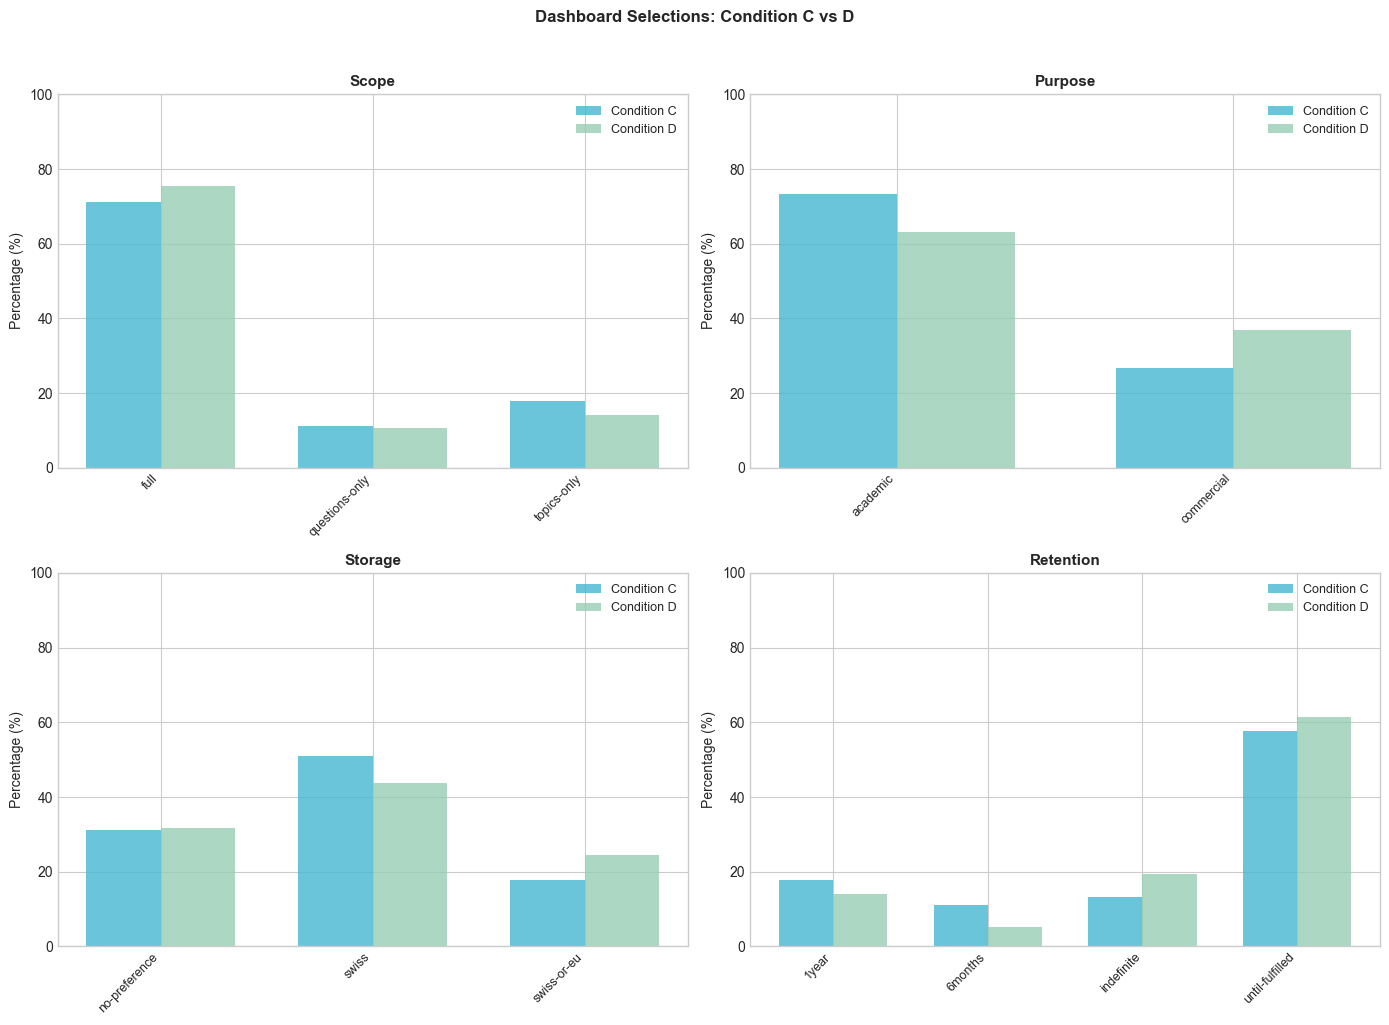

In [9]:
# Dashboard visualizations
if len(available_vars) >= 2:
    fig, axes = plt.subplots(2, 2, figsize=(14, 10))
    axes = axes.flatten()
    
    colors_cd = {'C': '#45B7D1', 'D': '#96CEB4'}
    
    for i, var in enumerate(available_vars[:4]):
        ax = axes[i]
        
        # Get data
        data_c = df_c1[df_c1['condition'] == 'C'][var].value_counts(normalize=True) * 100
        data_d = df_c1[df_c1['condition'] == 'D'][var].value_counts(normalize=True) * 100
        
        # Combine for plotting
        categories = sorted(set(data_c.index) | set(data_d.index))
        x = np.arange(len(categories))
        width = 0.35
        
        vals_c = [data_c.get(cat, 0) for cat in categories]
        vals_d = [data_d.get(cat, 0) for cat in categories]
        
        bars1 = ax.bar(x - width/2, vals_c, width, label='Condition C', color=colors_cd['C'], alpha=0.8)
        bars2 = ax.bar(x + width/2, vals_d, width, label='Condition D', color=colors_cd['D'], alpha=0.8)
        
        ax.set_xticks(x)
        ax.set_xticklabels([str(c)[:15] for c in categories], rotation=45, ha='right', fontsize=9)
        ax.set_ylabel('Percentage (%)', fontsize=10)
        ax.set_title(var.replace('dashboard_', '').title(), fontsize=11, fontweight='bold')
        ax.legend(fontsize=9)
        ax.set_ylim(0, 100)
    
    plt.suptitle('Dashboard Selections: Condition C vs D', fontsize=12, fontweight='bold', y=1.02)
    plt.tight_layout()
    plt.show()
else:
    print("Insufficient dashboard variables for visualization.")

## 6B: Q14 Open Text Analysis

In [10]:
print("6B: Q14 OPEN TEXT ANALYSIS")
print("=" * 70)
print("\nQ14: 'What mattered most for your data donation decision?'")

# Check if Q14 exists
q14_col = None
for col in ['open_feedback', 'q14', 'Q14', 'q14_text', 'open_text', 'decision_reason']:
    if col in df_filtered.columns:
        q14_col = col
        break

if q14_col:
    print(f"\nFound Q14 in column: {q14_col}")
    
    # Response rate
    total_n = len(df_filtered)
    non_empty = df_filtered[q14_col].dropna()
    non_empty = non_empty[non_empty.str.strip() != '']
    response_rate = len(non_empty) / total_n * 100
    
    print(f"Response rate: {len(non_empty)}/{total_n} ({response_rate:.1f}%)")
    
    # By condition
    print("\nResponse rate by condition:")
    for cond in ['A', 'B', 'C', 'D']:
        cond_df = df_filtered[df_filtered['condition'] == cond]
        cond_responses = cond_df[q14_col].dropna()
        cond_responses = cond_responses[cond_responses.str.strip() != '']
        cond_rate = len(cond_responses) / len(cond_df) * 100 if len(cond_df) > 0 else 0
        print(f"  {cond}: {len(cond_responses)}/{len(cond_df)} ({cond_rate:.1f}%)")
else:
    print("\nQ14 column not found in dataset.")
    print("Available columns:", list(df_filtered.columns))

6B: Q14 OPEN TEXT ANALYSIS

Q14: 'What mattered most for your data donation decision?'

Found Q14 in column: open_feedback
Response rate: 120/205 (58.5%)

Response rate by condition:
  A: 29/50 (58.0%)
  B: 34/53 (64.2%)
  C: 27/45 (60.0%)
  D: 30/57 (52.6%)


In [11]:
# ============================================================
# Multilingual Theme Codebook (DE / FR / EN)
# ============================================================
# Themes derived inductively from reading all 120 Q14 responses.
# Keywords sourced directly from participant language.
# Each response can match multiple themes (multi-label coding).
# Matching is case-insensitive substring search.

THEME_CODEBOOK = {
    'research_support': {
        'description': 'Donating to support research, science, or academic work',
        'keywords': {
            'de': ['forschung', 'wissenschaft', 'studie', 'akademisch', 'wissenschaftlerin'],
            'fr': ['recherche', 'étude', 'académique', 'scientifique'],
            'en': ['research', 'science', 'academic', 'study'],
        }
    },
    'improve_ai': {
        'description': 'Wanting to improve the chatbot, AI, or tool quality',
        'keywords': {
            'de': ['verbesser', 'weiterentwicklung', 'besser zu machen', 'optimiz', 'kompetent',
                    'qualität des', 'chatbot', 'bot lernt', 'ki-system', 'ki zu', 'ki hat',
                    'sinnvolle entwicklung', 'instrument'],
            'fr': ['améliorer', 'optimis'],
            'en': ['improve', 'better', 'develop', 'quality', 'open source'],
        }
    },
    'non_personal_data': {
        'description': 'Data viewed as non-sensitive, non-personal, or harmless',
        'keywords': {
            'de': ['nicht persönlich', 'keine persönlich', 'nicht auf mich', 'nicht zurückzuführ',
                    'nichts persönlich', 'nicht mega persönlich', 'allgemein', 'kein inhalt',
                    'keine exponation', 'nicht sehr persönlich', 'keine gefahr', 'wenig kritisch',
                    'nicht gegen mich', 'ausgewogen'],
            'fr': ['pas personnel', 'pas important'],
            'en': ['not personal', 'not sensitive', 'nothing personal', 'very general',
                    'not reveal', "didn't matter", "didn't contain"],
        }
    },
    'anonymity': {
        'description': 'Importance of anonymity or anonymization of data',
        'keywords': {
            'de': ['anonym', 'geheim'],
            'fr': ['anonymis', 'anonyme', 'discret'],
            'en': ['anonym'],
        }
    },
    'trust_institution': {
        'description': 'Trust in the institution, university, or researchers',
        'keywords': {
            'de': ['vertrauen', 'vertrauenswürdig', 'seriös', 'professionalität',
                    'epfl', 'eth', 'universität', 'öffentlich'],
            'fr': ['confiance', 'fiable', 'connaissance des initiateur'],
            'en': ['trust', 'trustworthy', 'reliable', 'credible'],
        }
    },
    'civic_democratic': {
        'description': 'Supporting democracy, voting information, or civic purpose',
        'keywords': {
            'de': ['demokrat', 'abstimmung', 'volksabstimmung', 'souverän', 'politisch',
                    'stimm', 'informationsbeschaffung', 'willensbildung', 'guten zweck',
                    'sinnvoll', 'positives'],
            'fr': ['démocrat', 'vote'],
            'en': ['democra', 'civic', 'voting', 'ballot', 'sovereig', 'good use'],
        }
    },
    'control_choice': {
        'description': 'Valuing having a choice or control over data donation',
        'keywords': {
            'de': ['wahlmöglichkeit', 'wahl hat', 'wahl haben', 'entscheid', 'beeinfluss',
                    'bestimmen konnt', 'ablehnen', 'wahl gegeben'],
            'fr': ['choix', 'choisir', 'contrôle'],
            'en': ['choice', 'choose', 'control', 'opt out', 'option', 'could choose'],
        }
    },
    'data_purpose': {
        'description': 'Concern about who uses the data and for what purpose',
        'keywords': {
            'de': ['zweck', 'verwendung', 'nutzung', 'kommerziell', 'privatwirtschaft',
                    'forschungszweck'],
            'fr': ['but', 'usage', 'commerc', 'utilisation'],
            'en': ['purpose', 'commercial', 'who will be using'],
        }
    },
    'data_storage_security': {
        'description': 'Concern about data storage location, duration, or security',
        'keywords': {
            'de': ['schweiz', 'speicher', 'server', 'dauer', 'standort', 'sicherheit',
                    'datenschutz'],
            'fr': ['stockage', 'suisse', 'sécurisé', 'sécurité'],
            'en': ['swiss', 'storage', 'server', 'store', 'retention', 'where',
                    'data protection'],
        }
    },
    'indifference': {
        'description': 'Indifference or lack of concern about the donation',
        'keywords': {
            'de': ['egal', 'spielt keine rolle', 'kein grund dagegen', 'nützts nüt',
                    'sprach kein grund'],
            'fr': ['fiche', 'peu importe'],
            'en': ["don't care", 'indifferen', "doesn't matter", "don't mind",
                    "didn't mind"],
        }
    },
}


def code_themes(text, codebook):
    """
    Identify themes in a text response using multilingual keyword matching.
    
    Returns list of matched theme names (multi-label).
    Case-insensitive substring matching across DE/FR/EN keywords.
    """
    if pd.isna(text) or str(text).strip() == '':
        return []
    
    text_lower = str(text).lower()
    themes_found = []
    
    for theme, config in codebook.items():
        matched = False
        for lang_keywords in config['keywords'].values():
            for keyword in lang_keywords:
                if keyword in text_lower:
                    matched = True
                    break
            if matched:
                break
        if matched:
            themes_found.append(theme)
    
    return themes_found


# Verify codebook
print(f"Multilingual theme codebook: {len(THEME_CODEBOOK)} themes")
for theme, config in THEME_CODEBOOK.items():
    n_kw = sum(len(v) for v in config['keywords'].values())
    print(f"  {theme}: {n_kw} keywords — {config['description']}")

Multilingual theme codebook: 10 themes
  research_support: 13 keywords — Donating to support research, science, or academic work
  improve_ai: 20 keywords — Wanting to improve the chatbot, AI, or tool quality
  non_personal_data: 23 keywords — Data viewed as non-sensitive, non-personal, or harmless
  anonymity: 6 keywords — Importance of anonymity or anonymization of data
  trust_institution: 15 keywords — Trust in the institution, university, or researchers
  civic_democratic: 19 keywords — Supporting democracy, voting information, or civic purpose
  control_choice: 17 keywords — Valuing having a choice or control over data donation
  data_purpose: 13 keywords — Concern about who uses the data and for what purpose
  data_storage_security: 18 keywords — Concern about data storage location, duration, or security
  indifference: 12 keywords — Indifference or lack of concern about the donation


In [12]:
# Code all responses and compute coverage
if q14_col:
    print("THEME CODING RESULTS")
    print("=" * 70)
    
    # Apply coding
    df_filtered = df_filtered.copy()
    df_filtered['themes'] = df_filtered[q14_col].apply(lambda x: code_themes(x, THEME_CODEBOOK))
    df_filtered['n_themes'] = df_filtered['themes'].apply(len)
    
    # Restrict to respondents only
    respondents = df_filtered[df_filtered[q14_col].notna() & (df_filtered[q14_col].str.strip() != '')].copy()
    n_respondents = len(respondents)
    
    # Coverage: how many responses matched at least one theme?
    coded = respondents[respondents['n_themes'] > 0]
    uncoded = respondents[respondents['n_themes'] == 0]
    
    print(f"\nCoverage: {len(coded)}/{n_respondents} responses matched >= 1 theme ({len(coded)/n_respondents*100:.1f}%)")
    print(f"Unmatched: {len(uncoded)}/{n_respondents} ({len(uncoded)/n_respondents*100:.1f}%)")
    print(f"Mean themes per response: {respondents['n_themes'].mean():.2f}")
    
    # Overall theme frequencies (% of respondents)
    all_themes = []
    for themes_list in respondents['themes']:
        all_themes.extend(themes_list)
    theme_counts = Counter(all_themes)
    
    print(f"\nOverall theme frequencies (% of {n_respondents} respondents):")
    print(f"{'Theme':<25} {'n':>4}  {'%':>6}")
    print("-" * 40)
    for theme, count in theme_counts.most_common():
        pct = count / n_respondents * 100
        print(f"  {theme:<23} {count:>4}  {pct:>5.1f}%")
    
    # Show unmatched responses for transparency
    if len(uncoded) > 0:
        print(f"\n--- Unmatched responses ({len(uncoded)}) ---")
        for _, row in uncoded.iterrows():
            print(f"  [{row['condition']}] {row[q14_col][:120]}")
else:
    print("Skipping theme coding - Q14 not available.")

THEME CODING RESULTS

Coverage: 112/120 responses matched >= 1 theme (93.3%)
Unmatched: 8/120 (6.7%)
Mean themes per response: 1.50

Overall theme frequencies (% of 120 respondents):
Theme                        n       %
----------------------------------------
  improve_ai                26   21.7%
  civic_democratic          21   17.5%
  research_support          20   16.7%
  non_personal_data         20   16.7%
  trust_institution         19   15.8%
  data_purpose              18   15.0%
  data_storage_security     17   14.2%
  anonymity                 17   14.2%
  control_choice            16   13.3%
  indifference               6    5.0%

--- Unmatched responses (8) ---
  [B] ich würde lieber etwas sagen, was ich vom chat halte. ich bin sehr besorgt! 
  [C] Dass meine Fragen sehr offen und neutral waren :-)
Viel Glück
  [A] of course you can have the data from the chat. this is some random sit - i'd avoid dumping anything (too) personal or po
  [B] das verantwortungsvoll mit den

Saved: ./output/phase6/fig_q14_theme_frequencies.png


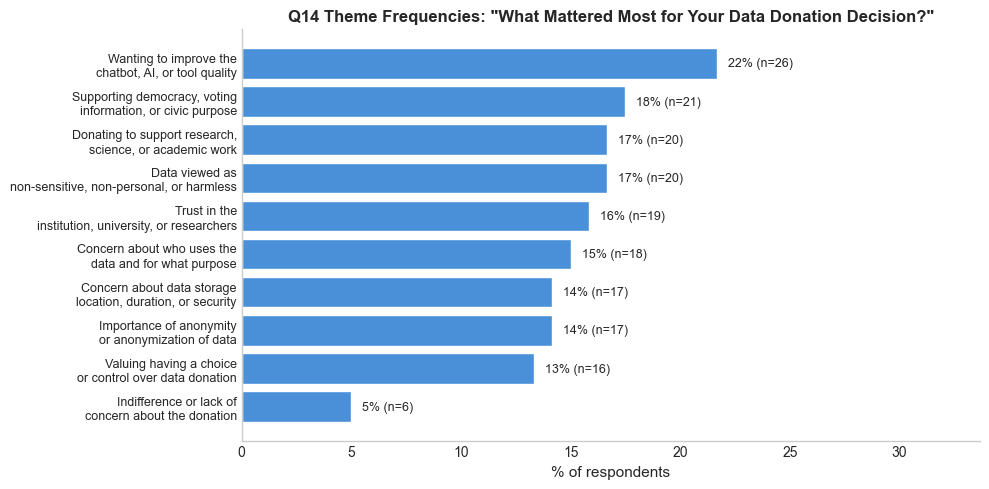

In [13]:
# Bar chart: Overall theme frequencies
if q14_col and theme_counts:
    os.makedirs('./output/phase6', exist_ok=True)
    fig, ax = plt.subplots(figsize=(10, 5))

    themes_sorted = theme_counts.most_common()
    labels = [THEME_CODEBOOK[t]['description'] for t, _ in themes_sorted]
    counts = [c for _, c in themes_sorted]
    pcts = [c / n_respondents * 100 for c in counts]

    # Wrap long labels
    labels_wrapped = []
    for lbl in labels:
        if len(lbl) > 40:
            words = lbl.split()
            mid = len(words) // 2
            lbl = ' '.join(words[:mid]) + '\n' + ' '.join(words[mid:])
        labels_wrapped.append(lbl)

    bars = ax.barh(range(len(labels_wrapped)), pcts, color='#4A90D9', edgecolor='white')
    ax.set_yticks(range(len(labels_wrapped)))
    ax.set_yticklabels(labels_wrapped, fontsize=9)
    ax.invert_yaxis()
    ax.set_xlabel('% of respondents', fontsize=11)
    ax.set_title('Q14 Theme Frequencies: "What Mattered Most for Your Data Donation Decision?"',
                 fontsize=12, fontweight='bold')

    # Add count labels
    for i, (pct, count) in enumerate(zip(pcts, counts)):
        ax.text(pct + 0.5, i, f'{pct:.0f}% (n={count})', va='center', fontsize=9)

    ax.set_xlim(0, max(pcts) + 12)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.grid(False)

    plt.tight_layout()
    fig.savefig('./output/phase6/fig_q14_theme_frequencies.png', dpi=150, bbox_inches='tight')
    print("Saved: ./output/phase6/fig_q14_theme_frequencies.png")
    plt.show()


In [14]:
# Theme frequencies by condition (% of respondents per condition)
if q14_col:
    print("THEME FREQUENCIES BY CONDITION (% of respondents)")
    print("=" * 70)
    
    theme_by_condition = {}
    n_respondents_by_cond = {}
    
    for cond in ['A', 'B', 'C', 'D']:
        cond_respondents = respondents[respondents['condition'] == cond]
        n_respondents_by_cond[cond] = len(cond_respondents)
        cond_themes = []
        for themes_list in cond_respondents['themes']:
            cond_themes.extend(themes_list)
        theme_by_condition[cond] = Counter(cond_themes)
    
    # Build comparison table
    all_theme_names = list(THEME_CODEBOOK.keys())
    comparison_data = []
    
    for theme in all_theme_names:
        row = {'Theme': theme}
        for cond in ['A', 'B', 'C', 'D']:
            count = theme_by_condition[cond].get(theme, 0)
            n_resp = n_respondents_by_cond[cond]
            pct = count / n_resp * 100 if n_resp > 0 else 0
            row[f'{cond} n'] = count
            row[f'{cond} (%)'] = round(pct, 1)
        # Overall
        total_count = theme_counts.get(theme, 0)
        row['Total n'] = total_count
        row['Total (%)'] = round(total_count / n_respondents * 100, 1)
        comparison_data.append(row)
    
    theme_comparison_df = pd.DataFrame(comparison_data)
    
    # Display sorted by total frequency
    display_cols = ['Theme', 'A n', 'A (%)', 'B n', 'B (%)', 'C n', 'C (%)', 'D n', 'D (%)', 'Total n', 'Total (%)']
    print(f"\nRespondents per condition: A={n_respondents_by_cond['A']}, B={n_respondents_by_cond['B']}, C={n_respondents_by_cond['C']}, D={n_respondents_by_cond['D']}")
    theme_comparison_df[display_cols].sort_values('Total n', ascending=False)

THEME FREQUENCIES BY CONDITION (% of respondents)

Respondents per condition: A=29, B=34, C=27, D=30


In [15]:
# Theme frequencies by donation decision (% of respondents in each group)
if q14_col:
    print("THEME FREQUENCIES BY DONATION DECISION (% of respondents)")
    print("=" * 70)
    
    theme_by_decision = {}
    n_resp_by_decision = {}
    
    for decision in [0, 1]:
        dec_respondents = respondents[respondents['donation_decision'] == decision]
        n_resp_by_decision[decision] = len(dec_respondents)
        dec_themes = []
        for themes_list in dec_respondents['themes']:
            dec_themes.extend(themes_list)
        theme_by_decision[decision] = Counter(dec_themes)
    
    print(f"\nRespondents: Declined={n_resp_by_decision[0]}, Donated={n_resp_by_decision[1]}")
    
    decision_comparison = []
    for theme in all_theme_names:
        n_decline = n_resp_by_decision[0]
        n_donate = n_resp_by_decision[1]
        
        count_decline = theme_by_decision[0].get(theme, 0)
        count_donate = theme_by_decision[1].get(theme, 0)
        
        pct_decline = count_decline / n_decline * 100 if n_decline > 0 else 0
        pct_donate = count_donate / n_donate * 100 if n_donate > 0 else 0
        
        decision_comparison.append({
            'Theme': theme,
            'Decline n': count_decline,
            'Decline (%)': round(pct_decline, 1),
            'Donate n': count_donate,
            'Donate (%)': round(pct_donate, 1),
            'Δ (pp)': round(pct_donate - pct_decline, 1)
        })
    
    decision_comparison_df = pd.DataFrame(decision_comparison)
    decision_comparison_df.sort_values('Δ (pp)', ascending=False)

THEME FREQUENCIES BY DONATION DECISION (% of respondents)

Respondents: Declined=5, Donated=115


In [16]:
# Condition contrasts (theme % differences between conditions)
if q14_col:
    print("CONDITION CONTRASTS (Theme % differences among respondents)")
    print("=" * 70)
    
    contrasts = [
        ('A', 'B', 'Effect of adding Data Nutrition Label (no dashboard)'),
        ('A', 'C', 'Effect of adding Granular Dashboard (no DNL)'),
        ('C', 'D', 'Effect of adding DNL (with dashboard)'),
        ('B', 'D', 'Effect of adding Dashboard (with DNL)')
    ]
    
    for cond1, cond2, description in contrasts:
        print(f"\n{cond1} → {cond2}: {description}")
        
        n1 = n_respondents_by_cond[cond1]
        n2 = n_respondents_by_cond[cond2]
        
        differences = []
        for theme in all_theme_names:
            pct1 = theme_by_condition[cond1].get(theme, 0) / n1 * 100 if n1 > 0 else 0
            pct2 = theme_by_condition[cond2].get(theme, 0) / n2 * 100 if n2 > 0 else 0
            diff = pct2 - pct1
            if abs(diff) >= 5:
                differences.append((theme, pct1, pct2, diff))
        
        if differences:
            differences.sort(key=lambda x: abs(x[3]), reverse=True)
            for theme, pct1, pct2, diff in differences:
                direction = '↑' if diff > 0 else '↓'
                print(f"  {theme:<25} {pct1:>5.1f}% → {pct2:>5.1f}% ({direction}{abs(diff):.1f} pp)")
        else:
            print("  No meaningful differences (>= 5 pp)")

CONDITION CONTRASTS (Theme % differences among respondents)

A → B: Effect of adding Data Nutrition Label (no dashboard)
  data_purpose                6.9% →  17.6% (↑10.8 pp)
  improve_ai                 31.0% →  20.6% (↓10.4 pp)
  control_choice             10.3% →   0.0% (↓10.3 pp)
  trust_institution          13.8% →  23.5% (↑9.7 pp)
  civic_democratic           13.8% →  20.6% (↑6.8 pp)
  non_personal_data          20.7% →  14.7% (↓6.0 pp)
  anonymity                  20.7% →  14.7% (↓6.0 pp)

A → C: Effect of adding Granular Dashboard (no DNL)
  control_choice             10.3% →  37.0% (↑26.7 pp)
  improve_ai                 31.0% →  14.8% (↓16.2 pp)
  indifference                6.9% →   0.0% (↓6.9 pp)
  non_personal_data          20.7% →  14.8% (↓5.9 pp)
  anonymity                  20.7% →  14.8% (↓5.9 pp)

C → D: Effect of adding DNL (with dashboard)
  control_choice             37.0% →  10.0% (↓27.0 pp)
  research_support           14.8% →  30.0% (↑15.2 pp)
  data_purpose   

In [17]:
# Representative quotes — one per top theme, stratified by language
if q14_col:
    print("REPRESENTATIVE QUOTES BY THEME")
    print("=" * 70)

    # Top themes by frequency
    top_themes = [t for t, _ in theme_counts.most_common()]

    quotes_shown = []
    for theme in top_themes:
        # Find respondents coded with this theme
        theme_respondents = respondents[respondents['themes'].apply(lambda ts: theme in ts)]
        if len(theme_respondents) == 0:
            continue

        # Pick a quote not yet used, preferring shorter illustrative ones
        for _, row in theme_respondents.iterrows():
            text = str(row[q14_col]).strip()
            if row.name not in quotes_shown and 10 < len(text) < 250:
                label = THEME_CODEBOOK[theme]['description']
                cond = row['condition']
                donated = 'Yes' if row['donation_decision'] == 1 else 'No'
                print(f"\n[{theme}] — {label}")
                print(f"  Condition {cond}, Donated: {donated}")
                print(f'  "{text}"')
                quotes_shown.append(row.name)
                break

    print(f"\n--- {len(quotes_shown)} quotes shown (one per theme) ---")


REPRESENTATIVE QUOTES BY THEME

[improve_ai] — Wanting to improve the chatbot, AI, or tool quality
  Condition D, Donated: Yes
  "I think it is important to help research of open source models"

[civic_democratic] — Supporting democracy, voting information, or civic purpose
  Condition D, Donated: Yes
  "Unterstütze die Informationsbeschaffung zu Abstimmungen"

[research_support] — Donating to support research, science, or academic work
  Condition B, Donated: Yes
  "Datenspende hilft der Forschung und am Ende uns allen!"

[non_personal_data] — Data viewed as non-sensitive, non-personal, or harmless
  Condition C, Donated: Yes
  "The chat was not important / didn't contain information that I consider to be of personal nature. So the donation choices didn't matter to me."

[trust_institution] — Trust in the institution, university, or researchers
  Condition B, Donated: Yes
  "That it is handled by institutions that I trust. But I found the documentation about the usage of my data very 

## Save Results

In [18]:
# Create output directory
output_dir = './output/phase6'
os.makedirs(output_dir, exist_ok=True)

# Save dashboard results
if len(available_vars) > 0:
    chi_results_df.to_csv(f'{output_dir}/phase6_dashboard_chi_square_{PARTICIPANT_TYPE}.csv', index=False)
    for var, freq_table in dashboard_freq_results.items():
        freq_table.to_csv(f'{output_dir}/phase6_{var}_frequencies_{PARTICIPANT_TYPE}.csv')

# Save Q14 results
if q14_col:
    theme_comparison_df.to_csv(f'{output_dir}/phase6_themes_by_condition_{PARTICIPANT_TYPE}.csv', index=False)
    decision_comparison_df.to_csv(f'{output_dir}/phase6_themes_by_decision_{PARTICIPANT_TYPE}.csv', index=False)

    # Save codebook as reference
    codebook_rows = []
    for theme, cfg in THEME_CODEBOOK.items():
        for lang, kws in cfg['keywords'].items():
            codebook_rows.append({
                'theme': theme,
                'description': cfg['description'],
                'language': lang,
                'keywords': ', '.join(kws)
            })
    pd.DataFrame(codebook_rows).to_csv(f'{output_dir}/phase6_theme_codebook.csv', index=False)

    # Save per-response coding for reproducibility
    response_coding = respondents[['condition', 'donation_decision', q14_col, 'themes', 'n_themes']].copy()
    response_coding['themes_str'] = response_coding['themes'].apply(lambda ts: '; '.join(ts) if ts else '')
    response_coding.drop(columns=['themes'], inplace=True)
    response_coding.to_csv(f'{output_dir}/phase6_q14_response_coding_{PARTICIPANT_TYPE}.csv', index=False)

print(f"Results saved to {output_dir}/")
print("  - Dashboard chi-square results")
print("  - Dashboard frequency tables (4 files)")
print("  - Theme frequencies by condition")
print("  - Theme frequencies by donation decision")
print("  - Theme codebook (DE/FR/EN keywords)")
print("  - Per-response coding (for reproducibility audit)")


Results saved to ./output/phase6/
  - Dashboard chi-square results
  - Dashboard frequency tables (4 files)
  - Theme frequencies by condition
  - Theme frequencies by donation decision
  - Theme codebook (DE/FR/EN keywords)
  - Per-response coding (for reproducibility audit)


In [19]:
# Final Summary
print("=" * 70)
print("PHASE 6 SUMMARY")
print("=" * 70)

# 6A Dashboard
n_sig_dashboard = sum(1 for r in chi_results if r.get('Significant') == 'Yes')
print(f"""
6A: DASHBOARD BEHAVIOR (Conditions C & D, n={len(df_c1)})
  Dashboard variables analyzed: {len(available_vars)}
  Chi-square tests (C vs D): {len(chi_results)} completed
  Significant differences: {n_sig_dashboard}
  → Dashboard preferences do NOT significantly differ between C and D""")

# 6B Q14
if q14_col:
    coded_pct = len(coded) / n_respondents * 100
    top3 = ', '.join([f"{t} ({c}/{n_respondents}, {c/n_respondents*100:.0f}%)" for t, c in theme_counts.most_common(3)])
    print(f"""
6B: Q14 OPEN TEXT ANALYSIS
  Respondents: {n_respondents}/{len(df_filtered)} ({n_respondents/len(df_filtered)*100:.1f}%)
  Codebook: {len(THEME_CODEBOOK)} themes, multilingual (DE/FR/EN)
  Coverage: {len(coded)}/{n_respondents} responses coded ({coded_pct:.1f}%)
  Mean themes per response: {respondents['n_themes'].mean():.2f}
  Top 3 themes: {top3}""")

print(f"""
REPRODUCIBILITY:
  Method: Deterministic keyword-based content analysis
  Codebook: {len(THEME_CODEBOOK)} themes × 3 languages (DE/FR/EN)
  All keywords, per-response codings, and codebook exported to CSV
""")


PHASE 6 SUMMARY

6A: DASHBOARD BEHAVIOR (Conditions C & D, n=102)
  Dashboard variables analyzed: 4
  Chi-square tests (C vs D): 4 completed
  Significant differences: 0
  → Dashboard preferences do NOT significantly differ between C and D

6B: Q14 OPEN TEXT ANALYSIS
  Respondents: 120/205 (58.5%)
  Codebook: 10 themes, multilingual (DE/FR/EN)
  Coverage: 112/120 responses coded (93.3%)
  Mean themes per response: 1.50
  Top 3 themes: improve_ai (26/120, 22%), civic_democratic (21/120, 18%), research_support (20/120, 17%)

REPRODUCIBILITY:
  Method: Deterministic keyword-based content analysis
  Codebook: 10 themes × 3 languages (DE/FR/EN)
  All keywords, per-response codings, and codebook exported to CSV



## Phase 6 Complete

The exploratory analysis is complete. Key outputs:

### 6A: Dashboard Behavior
1. Frequency tables for each dashboard variable (overall and by condition)
2. Chi-square tests comparing C vs D distributions
3. Top configuration profiles
4. Visualization of dashboard selections

### 6B: Q14 Open Text
1. Theme coding using keyword-based codebook
2. Theme frequencies by condition (A/B/C/D)
3. Theme frequencies by donation decision
4. Condition contrasts (A vs B, A vs C, C vs D, B vs D)
5. Representative quotes